
# PromptCraft — Colab-ready Notebook (OpenAI)
**Important — do NOT paste API keys into chat.** This notebook securely asks for your OpenAI API key using `getpass` when you run it in Google Colab.

**What this notebook does**
- Prompts you for your OpenAI API key (hidden input)
- Runs a minimal PromptCraft demo loop: *Practice → Execute (LLM) → Evaluate (unit tests) → Coach (LLM rewrite) → Memory*
- Uses SQLite for attempt storage and matplotlib for a simple progress plot
- Uses canned fallback logic when the LLM returns unparsable output

**How to use**
1. Upload this notebook to Google Colab.
2. Run the cells from top to bottom.
3. When prompted, paste your OpenAI API key into the hidden input field.
4. Inspect the demo runs and progress plot.



In [14]:

# Securely provide your OpenAI API key (it will be hidden and not printed)
from getpass import getpass
import os

openai_key = getpass('put your api key here')
if not openai_key:
    raise ValueError('No API key provided. Please rerun the cell and paste your key.')
os.environ['OPENAI_API_KEY'] = openai_key
print('OpenAI API key set in environment (hidden). Continue running the notebook.')


put your api key here··········
OpenAI API key set in environment (hidden). Continue running the notebook.


In [15]:

# Install client libraries if needed (uncomment if running fresh Colab)
# !pip install --quiet openai nbformat

import os, sqlite3, uuid, textwrap, json, re
from datetime import datetime
import matplotlib.pyplot as plt
from IPython.display import display, Markdown


In [16]:

# Initialize a simple SQLite DB for attempts (stored in /content for Colab)
DB_PATH = '/content/promptcraft.db'
conn = sqlite3.connect(DB_PATH, check_same_thread=False)
cur = conn.cursor()
cur.execute('''
CREATE TABLE IF NOT EXISTS attempts (
  id TEXT PRIMARY KEY,
  task_id TEXT,
  user_prompt TEXT,
  model_output TEXT,
  score REAL,
  created_at DATETIME DEFAULT CURRENT_TIMESTAMP
)
''')
conn.commit()
print('Database initialized at', DB_PATH)


Database initialized at /content/promptcraft.db


In [17]:

# Define deterministic tasks for evaluation (MVP)
TASKS = {
  "prime": {
    "desc": "Write a Python function is_prime(n) that returns True if n is prime, else False.",
    "tests": [
      ("is_prime(2)", True),
      ("is_prime(15)", False),
      ("is_prime(17)", True),
      ("is_prime(1)", False)
    ]
  },
  "fib": {
    "desc": "Write a Python function fib(n) that returns nth Fibonacci number (0-based index).",
    "tests": [
      ("fib(0)", 0),
      ("fib(1)", 1),
      ("fib(5)", 5),
      ("fib(10)", 55)
    ]
  }
}
print('Tasks loaded:', list(TASKS.keys()))


Tasks loaded: ['prime', 'fib']


In [18]:

# LLM wrapper using OpenAI 'openai' package (modern). The code uses the environment variable OPENAI_API_KEY.
# If you prefer a different client API, swap this implementation accordingly.
try:
    from openai import OpenAI
    client = OpenAI(api_key=os.environ.get('OPENAI_API_KEY'))
    def call_llm(prompt: str, model='gpt-4o', max_tokens=512) -> str:
        try:
            resp = client.responses.create(
                model=model,
                input=prompt,
                max_output_tokens=max_tokens
            )
            # Try convenience field if present
            if hasattr(resp, 'output_text') and resp.output_text:
                return resp.output_text
            # Fallback: join textual parts
            outputs = []
            if hasattr(resp, 'output') and resp.output:
                for item in resp.output:
                    # item may contain content elements
                    if hasattr(item, 'content'):
                        for c in item.content:
                            if hasattr(c, 'text'):
                                outputs.append(c.text)
                            else:
                                outputs.append(str(c))
                    else:
                        outputs.append(str(item))
            if outputs:
                return '\n'.join(outputs)
            return str(resp)
        except Exception as e:
            return f"# LLM call error: {e}"
    print('OpenAI client loaded. Using model:', 'gpt-4o (default)')
except Exception as e:
    print('OpenAI client import failed or not installed. Please install openai package or adjust client. Error:', e)
    def call_llm(prompt: str, model='gpt-4o', max_tokens=512) -> str:
        return '# LLM client not available in this environment. Replace call_llm with your provider client.'


OpenAI client loaded. Using model: gpt-4o (default)


In [19]:

# Evaluator: execute model output code and run unit tests (BE CAREFUL: this runs code in notebook)
def evaluate_code(code_str: str, task_id: str):
    local_env = {}
    try:
        exec(code_str, {}, local_env)
    except Exception as e:
        return 0.0, [('exec', str(e), None, False)]
    tests = TASKS[task_id]['tests']
    passed = 0
    details = []
    for expr, expected in tests:
        try:
            result = eval(expr, {}, local_env)
            ok = (result == expected)
            if ok: passed += 1
            details.append((expr, result, expected, ok))
        except Exception as e:
            details.append((expr, f'EXC:{e}', expected, False))
    score = (passed / len(tests)) * 100
    return score, details


In [20]:
# Coach: ask the LLM to return a JSON structured coaching response (diagnosis + 2 improved prompts)
def rewrite_prompt_with_llm(user_prompt: str, task_id: str):
    task_desc = TASKS[task_id]['desc']

    system = (
        "You are a friendly, concise prompt-engineering coach. "
        "Return valid JSON with the following keys: "
        "diagnosis, strict_prompt, concise_prompt, changes. "
        "Be brief and precise."
    )

    user_text = (
        f"User prompt: {user_prompt}\n"
        f"Task: {task_desc}\n"
        "Constraints: Provide only code when requested.\n"
        "Return only JSON.\n"
    )

    full_prompt = system + "\n\n" + user_text
    raw = call_llm(full_prompt)

    # Try to extract JSON from the LLM response
    try:
        out = json.loads(raw)
    except Exception:
        m = re.search(r"\{[\s\S]*\}", raw)
        if m:
            try:
                out = json.loads(m.group(0))
            except Exception:
                out = None
        else:
            out = None

    # Fallback if model returned invalid JSON
    if not out:
        out = {
            "diagnosis": "Model returned unparseable format or coaching failed; prompt may be vague.",
            "strict_prompt": f"Write a Python function: {task_desc}. Provide only code and handle edge cases.",
            "concise_prompt": f"Implement: {task_desc}. Return only the function code.",
            "changes": ["Made signature explicit", "Added edge-case instructions"]
        }
    return out

# Replace stub
rewrite_prompt = rewrite_prompt_with_llm
print('Coach function ready (uses call_llm).')


Coach function ready (uses call_llm).


In [21]:

# Orchestration: run one session (user prompt -> model -> evaluate -> store -> coach)
def run_session(task_id: str, user_prompt: str):
    attempt_id = str(uuid.uuid4())
    model_output = call_llm(user_prompt)
    score, details = evaluate_code(model_output, task_id)
    cur.execute('INSERT INTO attempts (id, task_id, user_prompt, model_output, score) VALUES (?,?,?,?,?)',
                (attempt_id, task_id, user_prompt, model_output, score))
    conn.commit()
    coach = rewrite_prompt(user_prompt, task_id)
    return {
        'attempt_id': attempt_id,
        'model_output': model_output,
        'score': score,
        'details': details,
        'coach': coach
    }

# Demo run: weak prompt -> coach -> rerun
print('Running demo with a weak prompt for task "prime"...')
weak_prompt = "Write is_prime quickly"
res = run_session('prime', weak_prompt)
print('\n--- DEMO: FIRST ATTEMPT ---')
print('User prompt:', weak_prompt)
print('\nModel output:\n', res['model_output'])
print('\nScore:', res['score'])
print('\nDetails:', res['details'])
print('\nCoach diagnosis:', res['coach']['diagnosis'])
print('\nCoach strict prompt suggestion:\n', res['coach']['strict_prompt'])

print('\nRe-running using coach strict prompt...')
res2 = run_session('prime', res['coach']['strict_prompt'])
print('\n--- DEMO: AFTER COACHING ---')
print('Coach prompt used:\n', res['coach']['strict_prompt'])
print('\nModel output after coaching:\n', res2['model_output'])
print('\nScore after coaching:', res2['score'])


Running demo with a weak prompt for task "prime"...

--- DEMO: FIRST ATTEMPT ---
User prompt: Write is_prime quickly

Model output:
 # LLM call error: Error code: 401 - {'error': {'message': 'Incorrect API key provided: AIzaSyAB***************************TQ6U. You can find your API key at https://platform.openai.com/account/api-keys.', 'type': 'invalid_request_error', 'param': None, 'code': 'invalid_api_key'}}

Score: 0.0

Details: [('is_prime(2)', "EXC:name 'is_prime' is not defined", True, False), ('is_prime(15)', "EXC:name 'is_prime' is not defined", False, False), ('is_prime(17)', "EXC:name 'is_prime' is not defined", True, False), ('is_prime(1)', "EXC:name 'is_prime' is not defined", False, False)]

Coach diagnosis: Model returned unparseable format or coaching failed; prompt may be vague.

Coach strict prompt suggestion:
 Write a Python function: Write a Python function is_prime(n) that returns True if n is prime, else False.. Provide only code and handle edge cases.

Re-running 

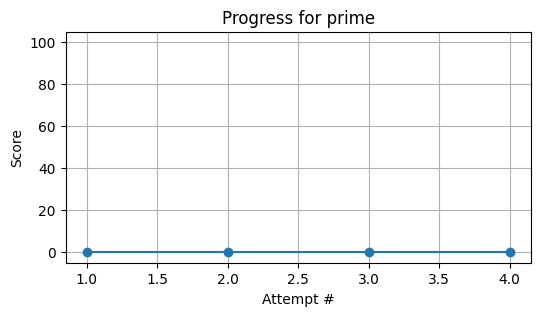

In [22]:

# Simple progress plot for a given task
def plot_progress(task_id: str):
    cur.execute('SELECT score, created_at FROM attempts WHERE task_id=? ORDER BY created_at', (task_id,))
    rows = cur.fetchall()
    if not rows:
        print('No attempts yet for', task_id)
        return
    scores = [r[0] for r in rows]
    times = list(range(1, len(scores)+1))
    plt.figure(figsize=(6,3))
    plt.plot(times, scores, marker='o')
    plt.ylim(-5, 105)
    plt.xlabel('Attempt #')
    plt.ylabel('Score')
    plt.title(f'Progress for {task_id}')
    plt.grid(True)
    plt.show()

plot_progress('prime')



## Next steps after running this notebook
- If outputs look good, record a short demo video showing:
  1. a weak prompt run (low score),
  2. coach suggestion,
  3. re-run with coach prompt (higher score),
  4. progress plot.
- To deploy a small UI, extract `run_session` and `TASKS` into a Python module and use Gradio/Flask. I can generate the Gradio `app.py` for you next.
- Do NOT share your API key in public or paste it into chat.

